<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap19/19_3_Monte_Carlo_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 19.3: Monte-Carlo methods**

This notebook investigates Monte Carlo methods for  tabular reinforcement learning as described in section 19.3.2 of the book

NOTE!  There is a mistake in Figure 19.11 in the first printing of the book, so check the errata to avoid becoming confused.  Apologies!

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.

Thanks to [Akshil Patel](https://www.akshilpatel.com) and [Jessica Nicholson](https://jessicanicholson1.github.io) for their help in preparing this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from IPython.display import clear_output
from time import sleep

In [2]:
# Get local copies of components of images
!wget https://raw.githubusercontent.com/udlbook/udlbook/main/Notebooks/Chap19/Empty.png
!wget https://raw.githubusercontent.com/udlbook/udlbook/main/Notebooks/Chap19/Hole.png
!wget https://raw.githubusercontent.com/udlbook/udlbook/main/Notebooks/Chap19/Fish.png
!wget https://raw.githubusercontent.com/udlbook/udlbook/main/Notebooks/Chap19/Penguin.png

--2024-08-27 10:39:47--  https://raw.githubusercontent.com/udlbook/udlbook/main/Notebooks/Chap19/Empty.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12495 (12K) [image/png]
Saving to: 'Empty.png.3'

     0K .......... ..                                         100% 7.99M=0.001s

2024-08-27 10:39:48 (7.99 MB/s) - 'Empty.png.3' saved [12495/12495]

--2024-08-27 10:39:48--  https://raw.githubusercontent.com/udlbook/udlbook/main/Notebooks/Chap19/Hole.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9440 (9.2K) [image/png]
Sav

In [3]:
# Ugly class that takes care of drawing pictures like in the book.
# You can totally ignore this code!
class DrawMDP:
  # Constructor initializes parameters
  def __init__(self, n_row, n_col):
    self.empty_image = np.asarray(Image.open('Empty.png'))
    self.hole_image = np.asarray(Image.open('Hole.png'))
    self.fish_image = np.asarray(Image.open('Fish.png'))
    self.penguin_image = np.asarray(Image.open('Penguin.png'))
    self.fig,self.ax = plt.subplots()
    self.n_row = n_row
    self.n_col = n_col

    my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
    my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
    r = np.floor(my_colormap_vals_dec/(256*256))
    g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
    b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
    self.colormap = np.vstack((r,g,b)).transpose()/255.0


  def draw_text(self, text, row, col, position, color):
    if position == 'bc':
      self.ax.text( 83*col+41,83 * (row+1) -5, text, horizontalalignment="center", color=color, fontweight='bold')
    if position == 'tc':
      self.ax.text( 83*col+41,83 * (row) +10, text, horizontalalignment="center", color=color, fontweight='bold')
    if position == 'lc':
      self.ax.text( 83*col+2,83 * (row) +41, text, verticalalignment="center", color=color, fontweight='bold', rotation=90)
    if position == 'rc':
      self.ax.text( 83*(col+1)-5,83 * (row) +41, text, horizontalalignment="right", verticalalignment="center", color=color, fontweight='bold', rotation=-90)
    if position == 'tl':
      self.ax.text( 83*col+5,83 * row +5, text, verticalalignment = 'top', horizontalalignment="left", color=color, fontweight='bold')
    if position == 'tr':
      self.ax.text( 83*(col+1)-5, 83 * row +5, text, verticalalignment = 'top', horizontalalignment="right", color=color, fontweight='bold')

  # Draws a set of states
  def draw_path(self, path, color1, color2):
    for i in range(len(path)-1):
      row_start = np.floor(path[i]/self.n_col)
      row_end = np.floor(path[i+1]/self.n_col)
      col_start = path[i] - row_start * self.n_col
      col_end = path[i+1] - row_end * self.n_col

      color_index = int(np.floor(255 * i/(len(path)-1.)))
      self.ax.plot([col_start * 83+41 + i, col_end * 83+41 + i ],[row_start * 83+41 +  i, row_end * 83+41 + i ], color=(self.colormap[color_index,0],self.colormap[color_index,1],self.colormap[color_index,2]))


  # Draw deterministic policy
  def draw_deterministic_policy(self,i, action):
      row = np.floor(i/self.n_col)
      col = i - row * self.n_col
      center_x = 83 * col + 41
      center_y = 83 * row + 41
      arrow_base_width = 10
      arrow_height = 15
      # Draw arrow pointing upward
      if action ==0:
          triangle_indices = np.array([[center_x, center_y-arrow_height/2],
                              [center_x - arrow_base_width/2, center_y+arrow_height/2],
                              [center_x + arrow_base_width/2, center_y+arrow_height/2]])
      # Draw arrow pointing right
      if action ==1:
          triangle_indices = np.array([[center_x + arrow_height/2, center_y],
                              [center_x - arrow_height/2, center_y-arrow_base_width/2],
                              [center_x - arrow_height/2, center_y+arrow_base_width/2]])
      # Draw arrow pointing downward
      if action ==2:
          triangle_indices = np.array([[center_x, center_y+arrow_height/2],
                              [center_x - arrow_base_width/2, center_y-arrow_height/2],
                              [center_x + arrow_base_width/2, center_y-arrow_height/2]])
      # Draw arrow pointing left
      if action ==3:
          triangle_indices = np.array([[center_x - arrow_height/2, center_y],
                              [center_x + arrow_height/2, center_y-arrow_base_width/2],
                              [center_x + arrow_height/2, center_y+arrow_base_width/2]])
      self.ax.fill(triangle_indices[:,0], triangle_indices[:,1],facecolor='cyan', edgecolor='darkcyan', linewidth=1)

  # Draw stochastic policy
  def draw_stochastic_policy(self,i, action_probs):
      row = np.floor(i/self.n_col)
      col = i - row * self.n_col
      offset = 20
      # Draw arrow pointing upward
      center_x = 83 * col + 41
      center_y = 83 * row + 41 - offset
      arrow_base_width = 15 * action_probs[0]
      arrow_height = 20 * action_probs[0]
      triangle_indices = np.array([[center_x, center_y-arrow_height/2],
                          [center_x - arrow_base_width/2, center_y+arrow_height/2],
                          [center_x + arrow_base_width/2, center_y+arrow_height/2]])
      self.ax.fill(triangle_indices[:,0], triangle_indices[:,1],facecolor='cyan', edgecolor='darkcyan', linewidth=1)

      # Draw arrow pointing right
      center_x = 83 * col + 41 + offset
      center_y = 83 * row + 41
      arrow_base_width = 15 * action_probs[1]
      arrow_height = 20 * action_probs[1]
      triangle_indices = np.array([[center_x + arrow_height/2, center_y],
                          [center_x - arrow_height/2, center_y-arrow_base_width/2],
                          [center_x - arrow_height/2, center_y+arrow_base_width/2]])
      self.ax.fill(triangle_indices[:,0], triangle_indices[:,1],facecolor='cyan', edgecolor='darkcyan', linewidth=1)

      # Draw arrow pointing downward
      center_x = 83 * col + 41
      center_y = 83 * row + 41 +offset
      arrow_base_width = 15 * action_probs[2]
      arrow_height = 20 * action_probs[2]
      triangle_indices = np.array([[center_x, center_y+arrow_height/2],
                          [center_x - arrow_base_width/2, center_y-arrow_height/2],
                          [center_x + arrow_base_width/2, center_y-arrow_height/2]])
      self.ax.fill(triangle_indices[:,0], triangle_indices[:,1],facecolor='cyan', edgecolor='darkcyan', linewidth=1)

      # Draw arrow pointing left
      center_x = 83 * col + 41 -offset
      center_y = 83 * row + 41
      arrow_base_width = 15 * action_probs[3]
      arrow_height = 20 * action_probs[3]
      triangle_indices = np.array([[center_x - arrow_height/2, center_y],
                          [center_x + arrow_height/2, center_y-arrow_base_width/2],
                          [center_x + arrow_height/2, center_y+arrow_base_width/2]])
      self.ax.fill(triangle_indices[:,0], triangle_indices[:,1],facecolor='cyan', edgecolor='darkcyan', linewidth=1)


  def draw(self, layout, state=None, draw_state_index= False, rewards=None, policy=None, state_values=None, state_action_values=None,path1=None, path2 = None):
    # Construct the image
    image_out = np.zeros((self.n_row * 83, self.n_col * 83, 4),dtype='uint8')
    for c_row in range (self.n_row):
      for c_col in range(self.n_col):
        if layout[c_row * self.n_col + c_col]==0:
          image_out[c_row*83:c_row*83+83, c_col*83:c_col*83+83,:] = self.empty_image
        elif layout[c_row * self.n_col + c_col]==1:
          image_out[c_row*83:c_row*83+83, c_col*83:c_col*83+83,:] = self.hole_image
        else:
          image_out[c_row*83:c_row*83+83, c_col*83:c_col*83+83,:] = self.fish_image
        if state is not None and state == c_row * self.n_col + c_col:
          image_out[c_row*83:c_row*83+83, c_col*83:c_col*83+83,:] = self.penguin_image

    # Draw the image
    plt.imshow(image_out)
    self.ax.get_xaxis().set_visible(False)
    self.ax.get_yaxis().set_visible(False)
    self.ax.spines['top'].set_visible(False)
    self.ax.spines['right'].set_visible(False)
    self.ax.spines['bottom'].set_visible(False)
    self.ax.spines['left'].set_visible(False)

    if draw_state_index:
      for c_cell in range(layout.size):
          self.draw_text("%d"%(c_cell), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'tl','k')

    # Draw the policy as triangles
    if policy is not None:
        # If the policy is deterministic
        if len(policy) == len(layout):
          for i in range(len(layout)):
            self.draw_deterministic_policy(i, policy[i])
        # Else it is stochastic
        else:
          for i in range(len(layout)):
            self.draw_stochastic_policy(i,policy[:,i])


    if path1 is not None:
      self.draw_path(path1, np.array([1.0, 0.0, 0.0]), np.array([0.0, 1.0, 1.0]))

    if rewards is not None:
        for c_cell in range(layout.size):
          self.draw_text("%d"%(rewards[c_cell]), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'tr','r')

    if state_values is not None:
        for c_cell in range(layout.size):
          self.draw_text("%2.2f"%(state_values[c_cell]), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'bc','black')

    if state_action_values is not None:
        for c_cell in range(layout.size):
          self.draw_text("%2.2f"%(state_action_values[0, c_cell]), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'tc','black')
          self.draw_text("%2.2f"%(state_action_values[1, c_cell]), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'rc','black')
          self.draw_text("%2.2f"%(state_action_values[2, c_cell]), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'bc','black')
          self.draw_text("%2.2f"%(state_action_values[3, c_cell]), np.floor(c_cell/self.n_col), c_cell-np.floor(c_cell/self.n_col)*self.n_col,'lc','black')



    plt.show()

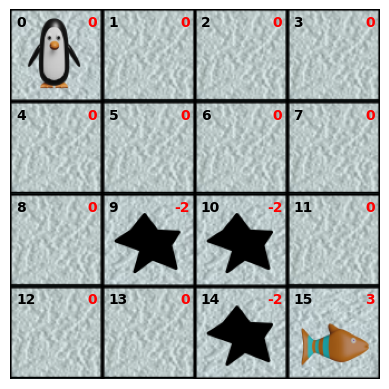

In [4]:
# We're going to work on the problem depicted in figure 19.10a
n_rows = 4; n_cols = 4
layout = np.zeros(n_rows * n_cols)
reward_structure = np.zeros(n_rows * n_cols)
layout[9] = 1 ; reward_structure[9] = -2    # Hole
layout[10] = 1; reward_structure[10] = -2   # Hole
layout[14] = 1; reward_structure[14] = -2   # Hole
layout[15] = 2; reward_structure[15] = 3    # Fish
initial_state = 0
mdp_drawer = DrawMDP(n_rows, n_cols)
mdp_drawer.draw(layout, state = initial_state, rewards=reward_structure, draw_state_index = True)

For clarity, the black numbers are the state number and the red numbers are the reward for being in that state.  Note that the states are indexed from 0 rather than 1 as in the book to make the code neater.

Now let's define the state transition function $Pr(s_{t+1}|s_{t},a)$ in full where $a$ is the actions.  Here $a=0$ means try to go upward, $a=1$, right, $a=2$ down and $a=3$ right.  However, the ice is slippery, so we don't always go the direction we want to.

Note that as for the states, we've indexed the actions from zero (unlike in the book) so they map to the indices of arrays better

In [5]:
transition_probabilities_given_action0 = np.array(\
[[0.90, 0.05, 0.00, 0.00,  0.85, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.05, 0.85, 0.05, 0.00,  0.00, 0.85, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.05, 0.85, 0.05,  0.00, 0.00, 0.85, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.05, 0.90,  0.00, 0.00, 0.00, 0.85,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.05, 0.00, 0.00, 0.00,  0.05, 0.05, 0.00, 0.00,  0.85, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.05, 0.00, 0.00,  0.05, 0.00, 0.05, 0.00,  0.00, 0.85, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.05, 0.00,  0.00, 0.05, 0.00, 0.05,  0.00, 0.00, 0.85, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.05, 0.05,  0.00, 0.00, 0.00, 0.85,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.05, 0.05, 0.00, 0.00,  0.85, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.05, 0.00, 0.00,  0.05, 0.00, 0.05, 0.00,  0.00, 0.85, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.05, 0.00,  0.00, 0.05, 0.00, 0.05,  0.00, 0.00, 0.85, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.05, 0.05,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.10, 0.05, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.05, 0.00, 0.00,  0.05, 0.05, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.05, 0.00,  0.00, 0.05, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.05, 0.00]])


transition_probabilities_given_action1 = np.array(\
[[0.10, 0.05, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.85, 0.05, 0.05, 0.00,  0.00, 0.05, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.85, 0.05, 0.05,  0.00, 0.00, 0.05, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.85, 0.90,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.05, 0.00, 0.00, 0.00,  0.05, 0.05, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.05, 0.00, 0.00,  0.85, 0.00, 0.05, 0.00,  0.00, 0.05, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.05, 0.00,  0.00, 0.85, 0.00, 0.05,  0.00, 0.00, 0.05, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.85, 0.85,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.05, 0.05, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.05, 0.00, 0.00,  0.85, 0.00, 0.05, 0.00,  0.00, 0.05, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.05, 0.00,  0.00, 0.85, 0.00, 0.05,  0.00, 0.00, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.85, 0.85,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.10, 0.05, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.05, 0.00, 0.00,  0.85, 0.05, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.05, 0.00,  0.00, 0.85, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.85, 0.00]])


transition_probabilities_given_action2 = np.array(\
[[0.10, 0.05, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.05, 0.05, 0.05, 0.00,  0.00, 0.05, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.05, 0.05, 0.05,  0.00, 0.00, 0.05, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.05, 0.10,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.85, 0.00, 0.00, 0.00,  0.05, 0.05, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.85, 0.00, 0.00,  0.05, 0.00, 0.05, 0.00,  0.00, 0.05, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.85, 0.00,  0.00, 0.05, 0.00, 0.05,  0.00, 0.00, 0.05, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.85,  0.00, 0.00, 0.05, 0.05,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.85, 0.00, 0.00, 0.00,  0.05, 0.05, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.85, 0.00, 0.00,  0.05, 0.00, 0.05, 0.00,  0.00, 0.05, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.85, 0.00,  0.00, 0.05, 0.00, 0.05,  0.00, 0.00, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.85,  0.00, 0.00, 0.05, 0.05,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.85, 0.00, 0.00, 0.00,  0.90, 0.05, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.85, 0.00, 0.00,  0.05, 0.85, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.85, 0.00,  0.00, 0.05, 0.85, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.85,  0.00, 0.00, 0.05, 0.00]])

transition_probabilities_given_action3 = np.array(\
[[0.90, 0.85, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.05, 0.05, 0.85, 0.00,  0.00, 0.05, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.05, 0.05, 0.85,  0.00, 0.00, 0.05, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.05, 0.10,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.05, 0.00, 0.00, 0.00,  0.85, 0.85, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.05, 0.00, 0.00,  0.05, 0.00, 0.85, 0.00,  0.00, 0.05, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.05, 0.00,  0.00, 0.05, 0.00, 0.85,  0.00, 0.00, 0.05, 0.00,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.05, 0.05,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.85, 0.85, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.05, 0.00, 0.00,  0.05, 0.00, 0.85, 0.00,  0.00, 0.05, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.05, 0.00,  0.00, 0.05, 0.00, 0.85,  0.00, 0.00, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.05, 0.05,  0.00, 0.00, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.05, 0.00, 0.00, 0.00,  0.90, 0.85, 0.00, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.05, 0.00, 0.00,  0.05, 0.05, 0.85, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.05, 0.00,  0.00, 0.05, 0.05, 0.00],
 [0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.00,  0.00, 0.00, 0.00, 0.05,  0.00, 0.00, 0.05, 0.00]])



# Store all of these in a three dimension array
# Pr(s_{t+1}=2|s_{t}=1, a_{t}=3] is stored at position [2,1,3]
transition_probabilities_given_action = np.concatenate((np.expand_dims(transition_probabilities_given_action0,2),
                                                        np.expand_dims(transition_probabilities_given_action1,2),
                                                        np.expand_dims(transition_probabilities_given_action2,2),
                                                        np.expand_dims(transition_probabilities_given_action3,2)),axis=2)

print('Grid Size:', len(transition_probabilities_given_action[0]))
print()
print('Transition Probabilities for when next state = 2:')
print(transition_probabilities_given_action[2])
print()
print('Transitions Probabilities for when next state = 2 and current state = 1')
print(transition_probabilities_given_action[2][1])
print()
print('Transitions Probabilities for  when next state = 2 and current state = 1 and action = 3 (Left):')
print(transition_probabilities_given_action[2][1][3])

Grid Size: 16

Transition Probabilities for when next state = 2:
[[0.   0.   0.   0.  ]
 [0.05 0.85 0.05 0.05]
 [0.85 0.05 0.05 0.05]
 [0.05 0.05 0.05 0.85]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.85 0.05 0.05 0.05]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]]

Transitions Probabilities for when next state = 2 and current state = 1
[0.05 0.85 0.05 0.05]

Transitions Probabilities for  when next state = 2 and current state = 1 and action = 3 (Left):
0.05


## Implementation Details

We provide the following methods:

- **`markov_decision_process_step_stochastic`** - this function selects an action based on the stochastic policy for the current state, updates the state based on the transition probabilities associated with the chosen action, and returns the new state, the reward obtained for the new state, the chosen action, and whether the episode terminates.

- **`get_one_episode`** - this function simulates an episode of agent-environment interaction. It returns the states, rewards, and actions seen in that episode, which we can then use to update the agent.

- **`calculate_returns`** - this function calls on the **`calculate_return`** function that computes the discounted sum of rewards from a specific step, in a sequence of rewards.

You have to implement the following methods:

- **`deterministic_policy_to_epsilon_greedy`** - given a deterministic policy, where one action is chosen per state, this function computes the $\epsilon$-greedy version of that policy, where each of the four actions has some nonzero probability of being selected per state. In each state, the probability of selecting each of the actions should sum to 1.

- **`update_policy_mc`** - this function updates the action-value function using the Monte Carlo method.  We use the rollout trajectories collected using `get_one_episode` to calculate the returns. Then update the action values towards the Monte Carlo estimate of the return for each state.

In [6]:
# This takes a single step from an MDP
def markov_decision_process_step_stochastic(state, transition_probabilities_given_action, reward_structure, terminal_states, stochastic_policy):
  # Pick action
  action = np.random.choice(a=np.arange(0,4,1),p=stochastic_policy[:,state])

  # Update the state
  new_state = np.random.choice(a=np.arange(0,transition_probabilities_given_action.shape[0]),p = transition_probabilities_given_action[:,state,action])
  # Return the reward
  reward = reward_structure[new_state]
  is_terminal = new_state in [terminal_states]

  return new_state, reward, action, is_terminal

In [7]:
# Run one episode and return actions, rewards, returns
def get_one_episode(initial_state, transition_probabilities_given_action, reward_structure, terminal_states, stochastic_policy):

    states  = []
    rewards = []
    actions = []

    states.append(initial_state)
    state = initial_state

    is_terminal = False
    # While we haven't reached a terminal state
    while not is_terminal:
        # Keep stepping through MDP
        state, reward, action, is_terminal = markov_decision_process_step_stochastic(state,
                                                                                     transition_probabilities_given_action,
                                                                                     reward_structure,
                                                                                     terminal_states,
                                                                                     stochastic_policy)
        states.append(state)
        rewards.append(reward)
        actions.append(action)

    states  = np.array(states, dtype="uint8")
    rewards = np.array(rewards)
    actions = np.array(actions, dtype="uint8")

    # If the episode was terminated early, we need to compute the return differently using r_{t+1} + gamma*V(s_{t+1})
    return states, rewards, actions

In [8]:
def visualize_one_episode(states, actions):
    # Define actions for visualization
    acts = ['up', 'right', 'down', 'left']

    # Iterate over the states and actions
    for i in range(len(states)):

        if i == 0:
            print('Starting State:', states[i])

        elif i == len(states)-1:
            print('Episode Done:', states[i])

        else:
            print('State', states[i-1])
            a = actions[i]
            print('Action:', acts[a])
            print('Next State:', states[i])

        # Visualize the current state using the MDP drawer
        mdp_drawer.draw(layout, state=states[i], rewards=reward_structure, draw_state_index=True)
        clear_output(True)

        # Pause for a short duration to allow observation
        sleep(1.5)


In [9]:
# Convert deterministic policy (1x16) to an epsilon greedy stochastic policy (4x16)
def deterministic_policy_to_epsilon_greedy(policy, epsilon=0.2):
  # TODO -- write this function
  # You should wind up with a 4x16 matrix, with epsilon/3 in every position except the real policy
  # The columns should sum to one
  # Replace this line:
    n_actions = 4
    n_states = len(policy)
    
    # Initialize the stochastic policy
    stochastic_policy = np.ones((n_actions, n_states)) * epsilon / n_actions
    
    # For each state, set the probability of the optimal action
    for state in range(n_states):
        optimal_action = policy[state]
        stochastic_policy[optimal_action, state] = 1 - epsilon + (epsilon / n_actions)
    


    return stochastic_policy

Let's try generating an episode

Initial Penguin Policy:
[2 1 3 0 2 1 3 2 0 2 1 1 3 1 1 2]

Stochastic Penguin Policy:
[[0.05 0.05 0.05 0.85 0.05 0.05 0.05 0.05 0.85 0.05 0.05 0.05 0.05 0.05
  0.05 0.05]
 [0.05 0.85 0.05 0.05 0.05 0.85 0.05 0.05 0.05 0.05 0.85 0.85 0.05 0.85
  0.85 0.05]
 [0.85 0.05 0.05 0.05 0.85 0.05 0.05 0.85 0.05 0.85 0.05 0.05 0.05 0.05
  0.05 0.85]
 [0.05 0.05 0.85 0.05 0.05 0.05 0.85 0.05 0.05 0.05 0.05 0.05 0.85 0.05
  0.05 0.05]]

Initial Penguin Position:


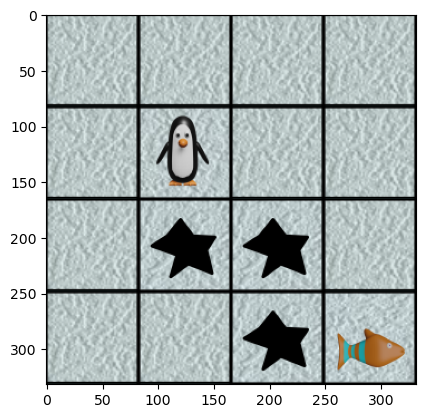

Total steps to termination: 11
Final Reward: 1.0


In [10]:
# Set seed so random numbers always the same
np.random.seed(6)
# Print in compact form
np.set_printoptions(precision=3)

# Let's start with by setting the policy randomly
policy = np.random.choice(size= n_rows * n_cols, a=np.arange(0,4,1))

# Convert deterministic policy to stochastic
stochastic_policy = deterministic_policy_to_epsilon_greedy(policy)

print("Initial Penguin Policy:")
print(policy)
print()
print('Stochastic Penguin Policy:')
print(stochastic_policy)
print()

initial_state = 5
terminal_states=[15]
states, rewards, actions = get_one_episode(initial_state,transition_probabilities_given_action, reward_structure, terminal_states, stochastic_policy)

print('Initial Penguin Position:')
mdp_drawer.draw(layout, state = initial_state, rewards=reward_structure, draw_state_index = True)

print('Total steps to termination:', len(states))
print('Final Reward:', np.sum(rewards))

Episode Done: 15


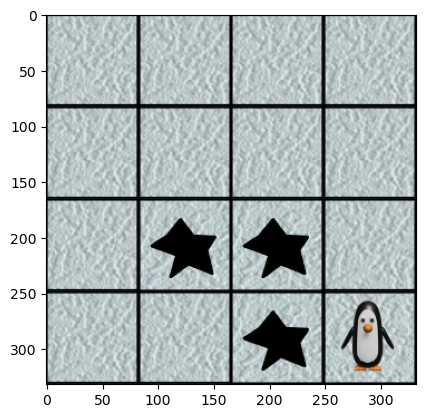

In [11]:
#this visualizes the complete episode
visualize_one_episode(states, actions)

We'll need to calculate the returns (discounted cumulative reward) for each state action pair

In [15]:
def calculate_returns(rewards, gamma):
  returns = np.zeros(len(rewards))
  for c_return in range(len(returns)):
    returns[c_return] = calculate_return(rewards[c_return:], gamma)
  return returns

def calculate_return(rewards, gamma):
  return_val = 0.0
  for i in range(len(rewards)):
      return_val += rewards[i] * np.power(gamma, i)
  return return_val

This routine does the main work of the on-policy Monte Carlo method.  We repeatedly rollout episods, calculate the returns.  Then we figure out the average return for each state action pair, and choose the next policy as the action that has greatest state action value at each state.

In [16]:
def update_policy_mc(initial_state, transition_probabilities_given_action, reward_structure, terminal_states, stochastic_policy, gamma, n_rollouts=1):
  # Create two matrices to store total returns for each action/state pair and the
  # number of times we observed that action/state pair
  n_state = transition_probabilities_given_action.shape[0]
  n_action = transition_probabilities_given_action.shape[2]
  # Contains the total returns seen for taking this action at this state
  state_action_returns_total = np.zeros((n_action, n_state))
  # Contains the number of times we have taken this action in this state
  state_action_count = np.zeros((n_action,n_state))

  # For each rollout
  for c_rollout in range(n_rollouts):
      # TODO -- Complete this function
      # 1. Draw a random state from 0 to 14
      start_state = np.random.randint(0, 15)  # 15 is excluded
      # 2. Get one episode starting at that state
      states, rewards, actions = get_one_episode(start_state, transition_probabilities_given_action, 
                                                   reward_structure, terminal_states, stochastic_policy)
      # 3. Compute the returns
      returns = calculate_returns(rewards, gamma)
      # 4. For each position in the trajectory, update state_action_returns_total and state_action_count
      for t in range(len(states) - 1):  # -1 because the last state doesn't have an action
          state = states[t]
          action = actions[t]
          state_action_returns_total[action, state] += returns[t]
          state_action_count[action, state] += 1


  # Normalize -- add small number to denominator to avoid divide by zero
  state_action_values = state_action_returns_total/( state_action_count+0.00001)
  policy = np.argmax(state_action_values, axis=0).astype(int)
  return policy, state_action_values


Initial policy:
[0 3 1 0 3 3 3 3 1 3 1 2 0 3 2 0]


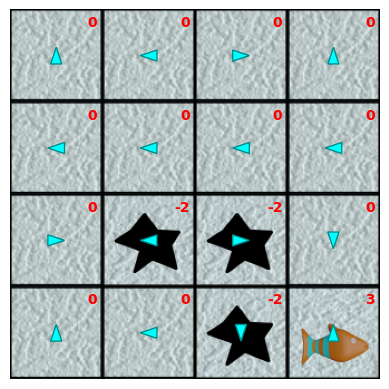

Updated policy
[1 3 0 3 0 0 2 1 0 0 1 2 3 3 1 0]


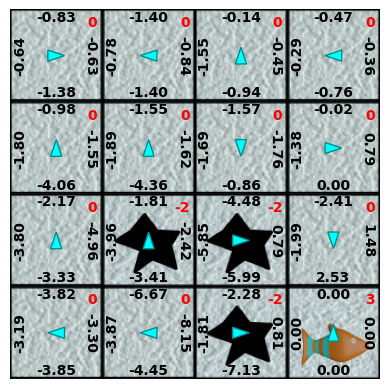

Updated policy
[2 2 1 0 3 1 0 1 0 0 1 2 1 1 1 0]


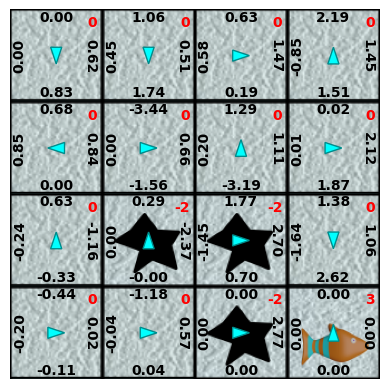

Updated policy
[1 1 3 2 0 0 1 2 2 3 0 2 1 2 1 0]


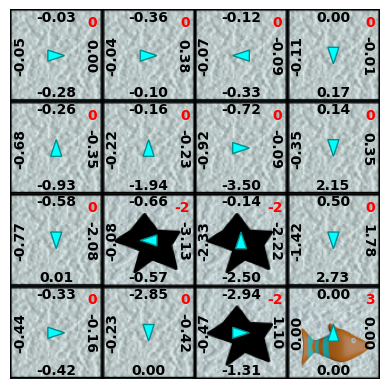

Updated policy
[3 1 1 1 0 1 1 2 3 3 1 2 2 0 1 0]


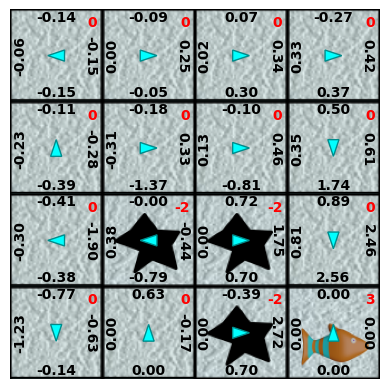

Updated policy
[3 1 2 2 0 3 1 3 0 2 0 2 2 2 1 0]


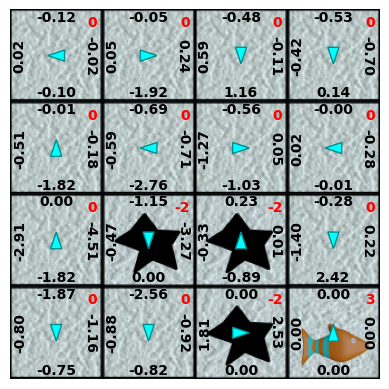

Updated policy
[1 1 2 0 1 1 1 1 3 1 1 2 0 3 1 0]


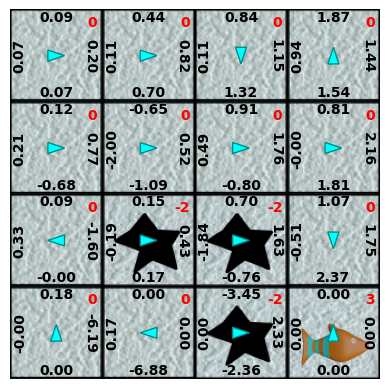

Updated policy
[3 0 1 2 2 3 1 1 3 2 1 1 1 1 1 0]


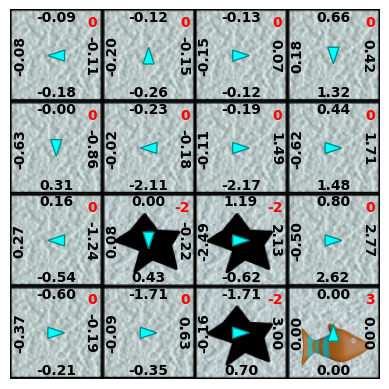

Updated policy
[0 1 1 1 0 1 1 0 0 3 1 2 2 1 1 0]


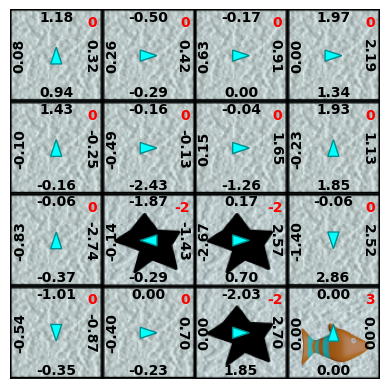

Updated policy
[3 1 1 2 0 3 0 3 0 0 0 1 3 1 1 0]


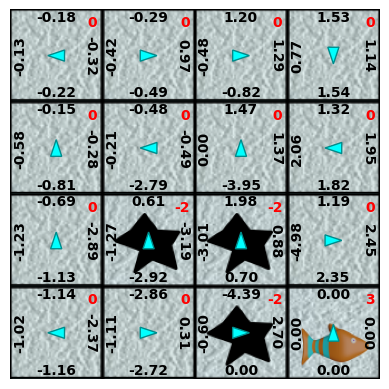

Updated policy
[0 1 2 2 2 0 1 1 0 1 1 2 2 1 1 0]


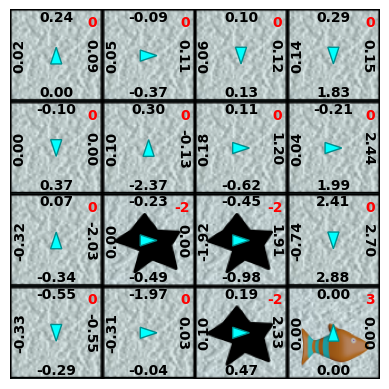

Updated policy
[2 0 1 1 0 0 1 2 2 2 1 2 3 2 1 0]


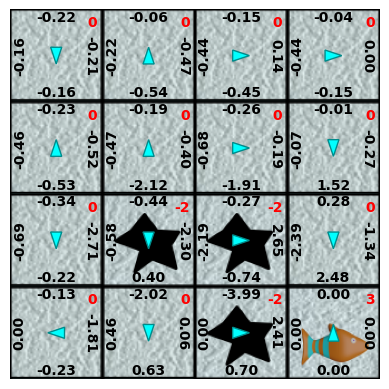

In [17]:
# Set seed so random numbers always the same
np.random.seed(0)
# Print in compact form
np.set_printoptions(precision=3)

# Let's start with by setting the policy randomly
policy = np.random.choice(size= n_rows * n_cols, a=np.arange(0,4,1))
gamma = 0.9
print("Initial policy:")
print(policy)
mdp_drawer = DrawMDP(n_rows, n_cols)
mdp_drawer.draw(layout, policy = policy, rewards = reward_structure)

terminal_states = [15]
# Track all the policies so we can visualize them later
all_policies = []
n_policy_update = 2000
for c_policy_update in range(n_policy_update):
    # Convert policy to stochastic
    stochastic_policy = deterministic_policy_to_epsilon_greedy(policy)
    # Update policy by Monte Carlo method
    policy, state_action_values = update_policy_mc(initial_state, transition_probabilities_given_action, reward_structure, terminal_states, stochastic_policy, gamma, n_rollouts=100)
    all_policies.append(policy)

    # Print out 10 snapshots of progress
    if (c_policy_update % (n_policy_update//10) == 0) or c_policy_update == n_policy_update - 1:
        print("Updated policy")
        print(policy)
        mdp_drawer = DrawMDP(n_rows, n_cols)
        mdp_drawer.draw(layout, policy = policy, rewards = reward_structure, state_action_values=state_action_values)




You can see a definite improvement to the policy